# Time Series Analysis in Python

From stock prices to climate data, time series data are found in a wide variety of domains, and being able to effectively work with such data is an increasingly important skill for data scientists. This course will introduce us to time series analysis in Python. After learning about what a time series is, we'll learn about several time series models ranging from autoregressive and moving average models to cointegration models. Along the way, we'll learn how to estimate, forecast, and simulate these models using statistical libraries in Python. We'll see numerous examples of how these models are used, with a particular emphasis on applications in finance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
# import datetime module
import datetime
# Import the statsmodels module
import statsmodels.api as sm
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
# Import the module for plotting the PACF, ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
# Import the plot_predict from statsmodels
from statsmodels.graphics.tsaplots import plot_predict

## 1. Correlation and Autocorrelation

In this chapter we'll be introduced to the ideas of correlation and autocorrelation for time series. Correlation describes the relationship between two time series and autocorrelation describes the relationship of a time series with its past values.

#### Introduction to the Course

[Google Trends](https://trends.google.com/trends/?geo=IL) allows users to see how often a term is searched for. We downloaded a file from Google Trends containing the frequency over time for the search word "diet", which we will load. 

A first step when analyzingdiet a time series is to visualize the data with a plot. We should be able to clearly see a gradual decrease in searches for "diet" throughout the calendar year, hitting a low around the December holidays, followed by a spike in searches around the new year as people make New Year's resolutions to lose weight.

Like many time series datasets we will be working with, the index of dates are strings and should be converted to a datetime index before plotting.

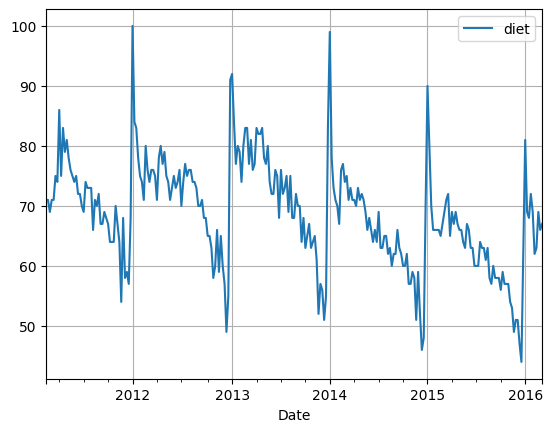

In [2]:
diet = pd.read_csv("data_1\diet.csv", parse_dates = ['Date'], index_col='Date')


# Plot the entire time series diet and show gridlines
diet.plot(grid=True)
plt.show()

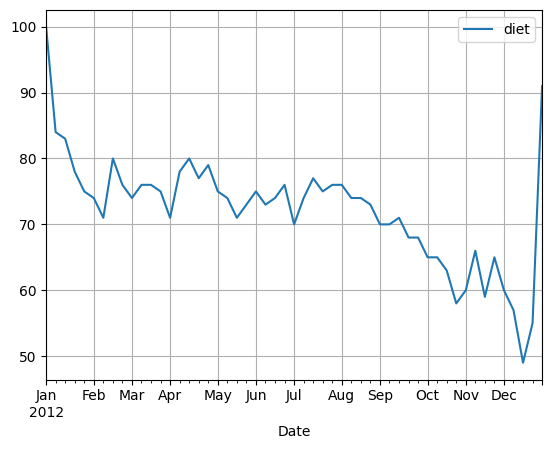

In [3]:
# Slice the dataset to keep only 2012
diet2012 = diet.loc['2012']

# Plot 2012 data
diet2012.plot(grid=True)
plt.show()

Stock and bond markets in the U.S. are closed on different days. For example, although the bond market is closed on Columbus Day (around Oct 12) and Veterans Day (around Nov 11), the stock market is open on those days. One way to see the dates that the stock market is open and the bond market is closed is to convert both indexes of dates into sets and take the difference in sets.

The pandas `.join()` method is a convenient tool to merge the stock and bond DataFrames on dates when both markets are open.

Stock prices and [10-year US Government bond yields](https://fred.stlouisfed.org/series/DGS10), which were downloaded from [FRED](https://fred.stlouisfed.org/).

In [4]:
stocks = pd.read_csv("data_1\SP500.csv", index_col='DATE')
stocks.index = pd.to_datetime(stocks.index, format='%Y-%m-%d')
bonds = pd.read_csv("data_1\Bonds.csv", index_col='DATE')
bonds.index = pd.to_datetime(bonds.index, format='%Y-%m-%d')

# Convert the stock index and bond index into sets
set_stock_dates = set(stocks.index)
set_bond_dates = set(bonds.index)

# Take the difference between the sets and print
print(set_stock_dates - set_bond_dates)

# Merge stocks and bonds DataFrames using join()
stocks_and_bonds = stocks.join(bonds, how="inner")

{Timestamp('2018-10-08 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2018-11-12 00:00:00'), Timestamp('2020-11-11 00:00:00'), Timestamp('2019-11-11 00:00:00'), Timestamp('2022-10-10 00:00:00'), Timestamp('2022-11-11 00:00:00'), Timestamp('2021-11-11 00:00:00'), Timestamp('2019-10-14 00:00:00'), Timestamp('2021-10-11 00:00:00')}


#### Simple Linear Regression

Investors are often interested in the correlation between the returns of two different assets for asset allocation and hedging purposes. In this exercise, we'll try to answer the question of whether stocks are positively or negatively correlated with bonds. Scatter plots are also useful for visualizing the correlation between the two variables.

Keep in mind that we should compute the correlations on the percentage changes rather than the levels.

Stock prices and 10-year bond yields are combined in a DataFrame called stocks_and_bonds under columns SP500 and US10Y

The pandas and plotting modules have already been imported for you. For the remainder of the course, pandas is imported as pd and matplotlib.pyplot is imported as plt.

Correlation of stocks and interest rates:  0.31242301504562836


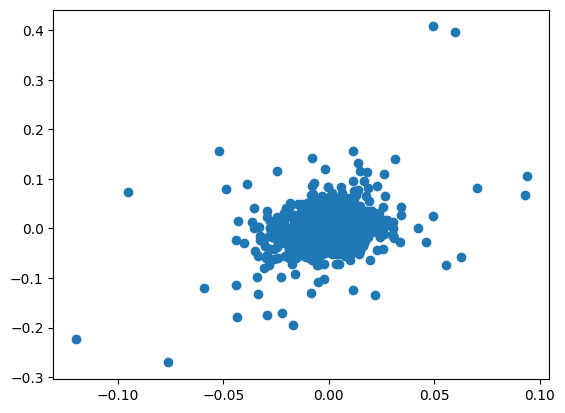

In [5]:
# Compute percent change using pct_change()
returns = stocks_and_bonds.pct_change()

# Compute correlation using corr()
correlation = returns['SP500'].corr(returns['US10Y'])
print("Correlation of stocks and interest rates: ", correlation)

# Make scatter plot
plt.scatter(returns['SP500'], returns['US10Y'])
plt.show()

The positive correlation means that when interest rates go down, stock prices go down. For example, during crises like 9/11, investors sold stocks and moved their money to less risky bonds (this is sometimes referred to as a 'flight to quality'). During these periods, stocks drop and interest rates drop as well. Of course, there are times when the opposite relationship holds too.

Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as "spurious correlation". That's why when you look at the correlation of say, two stocks, you should look at the correlation of their returns and not their levels.

To illustrate this point, calculate the correlation between the levels of the stock market and the annual sightings of UFOs. Both of those time series have trended up over the last several decades, and the correlation of their levels is very high. Then calculate the correlation of their percent changes. This will be close to zero, since there is no relationship between those two series.

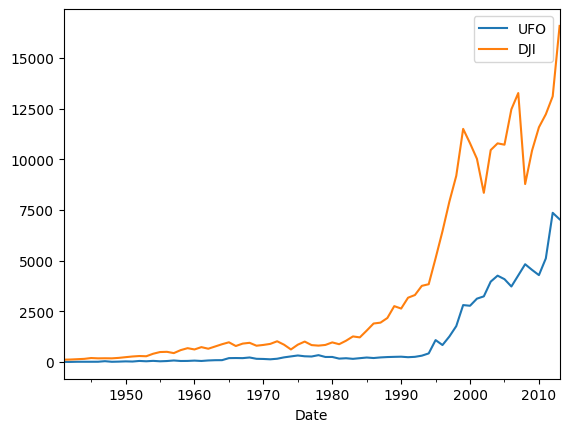

In [6]:
ufo = pd.read_csv("data_1\data_ufo.csv", parse_dates=["Date"], index_col='Date')
dji = pd.read_csv("data_1\DJI.csv", parse_dates=["Date"], index_col='Date')

levels = ufo.join(dji, how="inner")
levels.plot()
plt.show()

In [7]:
# Compute correlation of levels
correlation1 = levels["DJI"].corr(levels["UFO"])
print("Correlation of levels: ", correlation1)

# Compute correlation of percent changes
changes = levels.pct_change()
correlation2 = changes["DJI"].corr(changes["UFO"])
print("Correlation of changes: ", correlation2)

Correlation of levels:  0.9399762210726432
Correlation of changes:  0.06026935462405376


Notice that the correlation on levels is high but the correlation on changes is close to zero.

#### Simple Linear Regression

R-squared measures how closely the data fit the regression line, so the R-squared in a simple regression is related to the correlation between the two variables. In particular, the magnitude of the correlation is the square root of the R-squared and the sign of the correlation is the sign of the regression coefficient.

In this exercise, we will start using the statistical package `statsmodels`, which performs much of the statistical modeling and testing that is found in R and software packages like SAS and MATLAB.

For this exercise, we will take `Apple` (dependent parameter) and `Google` (independent parameter) data, compute their correlation, and then regress `Apple` and `Google` using the function `OLS(y,x)` in the `statsmodels.api` library (note that the dependent, or right-hand side variable `y` is the first argument). Most linear regressions contain a constant term which is the intercept (the $\alpha$ in the regression $y_t = \alpha + \beta x_t + \epsilon _t$). To include a constant using the function `OLS()`, we need to add a column of 1's to the right hand side of the regression.

In [8]:
data = pd.read_csv('data/apple_google.csv', parse_dates=['Date'], index_col='Date')
data.dropna(inplace=True)
print(data.head())
print(40*'#')

             AAPL    GOOG
Date                     
2010-12-16  45.89  295.56
2010-12-17  45.80  295.10
2010-12-20  46.03  297.23
2010-12-21  46.32  301.23
2010-12-22  46.45  302.44
########################################


In [9]:


# Compute correlation of x and y
correlation = data['AAPL'].corr(data['GOOG'])
print("The correlation between x and y is %4.2f" %(correlation))


# Add a constant to the DataFrame dfx
dfx = sm.add_constant(data)

# Regress y on dfx1
result = sm.OLS(dfx['AAPL'], dfx[['const', 'GOOG']]).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

The correlation between x and y is 0.79
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2748.
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:12:54   Log-Likelihood:                -6843.5
No. Observations:                1624   AIC:                         1.369e+04
Df Residuals:                    1622   BIC:                         1.370e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

The R-squared is a squared correlation.

#### A Popular Strategy Using Autocorrelation

One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as mean reversion in stock prices: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe mean reversion is to say that stock returns are negatively autocorrelated.

This simple idea is actually the basis for a popular hedge fund strategy (see [here](https://web.mit.edu/Alo/www/Papers/august07.pdf)).

We'll look at the autocorrelation of weekly returns of `MSFT` stock from 2012 to 2017. We'll start with a DataFrame `MSFT` of daily prices. We should use the `.resample()` method to get weekly prices and then compute returns from prices. We will use the pandas method `.autocorr()` to get the autocorrelation and show that the autocorrelation is negative. Note that the `.autocorr()` method only works on Series, not DataFrames (even DataFrames with one column), so we will have to select the column in the DataFrame.

In [10]:
MSFT = pd.read_csv('data_1/MSFT.csv', parse_dates=['Date'], index_col='Date')
print(MSFT.head())
print(40*'#')

            Adj Close
Date                 
2012-08-06  26.107651
2012-08-07  26.377876
2012-08-08  26.438896
2012-08-09  26.587088
2012-08-10  26.517351
########################################


In [11]:
# Convert the daily data to weekly data
MSFT = MSFT.resample(rule='W').last()

# Compute the percentage change of prices
returns = MSFT.pct_change()

# Compute and print the autocorrelation of returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.16


The autocorrelation of returns for MSFT is negative, so the stock is 'mean reverting'.

When you look at daily changes in interest rates, the autocorrelation is close to zero. However, if you resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

In [12]:
daily_rates = pd.read_csv("data_1\Bonds.csv", index_col='DATE')
daily_rates.index = pd.to_datetime(bonds.index, format='%Y-%m-%d')
print(daily_rates.head())
print(40*'#')

            US10Y
DATE             
2018-03-06   2.88
2018-03-07   2.89
2018-03-08   2.86
2018-03-09   2.90
2018-03-12   2.87
########################################


In [13]:
# Compute the daily change in interest rates 
daily_diff = daily_rates.diff()

# Compute and print the autocorrelation of daily changes
autocorrelation_daily = daily_diff['US10Y'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

# Convert the daily data to annual data
yearly_rates = daily_rates.resample(rule='A').last()

# Repeat above for annual data
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff['US10Y'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_yearly))

The autocorrelation of daily interest rate changes is 0.01
The autocorrelation of annual interest rate changes is 0.18


## 2. Some Simple Time Series
In this chapter we'll learn about some simple time series models. These include white noise and a random walk.

#### Autocorrelation Function

In the last chapter, we computed autocorrelations with one lag. Often we are interested in seeing the autocorrelation over many lags. 

In [14]:
HRB = pd.read_csv("data_1\HRB.csv", parse_dates = ['Quarter'], index_col='Quarter')
HRB.head()

,Earnings
Quarter,
2007-01-01,-0.36
2007-04-01,-0.38
2007-07-01,0.07
2007-10-01,1.85
2008-01-01,-0.34


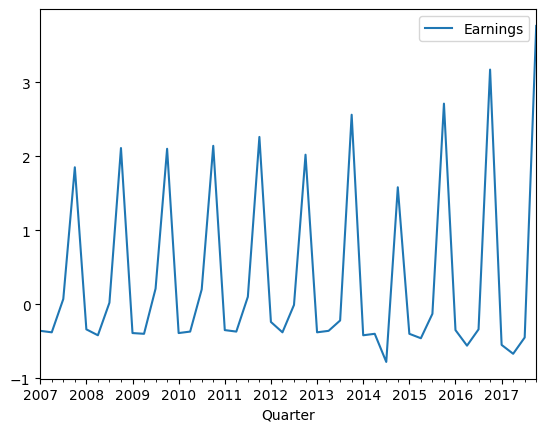

In [15]:
HRB.plot()
plt.show()

The quarterly earnings for H&R Block (ticker symbol HRB) is plotted above, and we can see the extreme cyclicality of its earnings. A vast majority of its earnings occurs in the quarter that taxes are due.

WE will compute the array of autocorrelations for the H&R Block quarterly earnings that is pre-loaded in the DataFrame `HRB`. Then, plot the autocorrelation function using the `plot_acf` module. This plot shows what the autocorrelation function looks like for cyclical earnings data. The ACF at `lag=0` is always one, of course. In the next exercise, we will learn about the confidence interval for the ACF, but for now, we will suppress the confidence interval by setting `alpha=1`.

[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259 ]


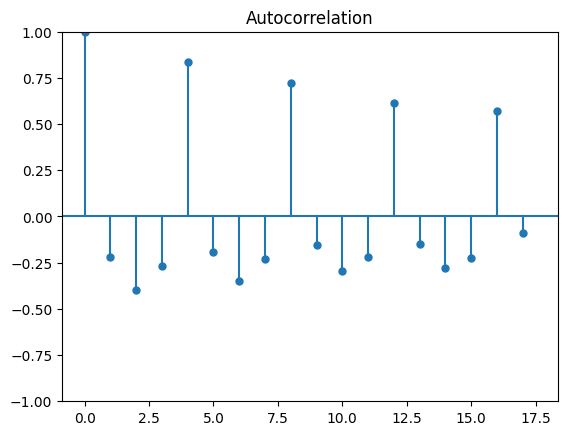

In [16]:
# Compute the acf array of HRB
acf_array = acf(HRB)
print(acf_array)

# Plot the acf function
plot_acf(HRB, alpha=1)
plt.show()

Notice the strong positive autocorrelation at lags 4, 8, 12, 16, 20, ...

In the last chapter, we saw that the autocorrelation of MSFT's weekly stock returns was -0.16. That autocorrelation seems large, but __is it statistically significant?__ In other words, can we say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero? And are there any autocorrelations at other lags that are significantly different from zero?

Even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is $ 1 / \sqrt{N}  $ where $N$ is the number of observations, so if $N=100$, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is $ \pm 1.96 / \sqrt{N}$. This approximation only holds when the true autocorrelations are all zero.

We will compute the actual and approximate confidence interval for the ACF, and compare it to the lag-one autocorrelation of -0.16 from the last chapter.

In [17]:
print(MSFT.head())

            Adj Close
Date                 
2012-08-12  26.517351
2012-08-19  27.114212
2012-08-26  26.815865
2012-09-02  27.044012
2012-09-09  27.158091


The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


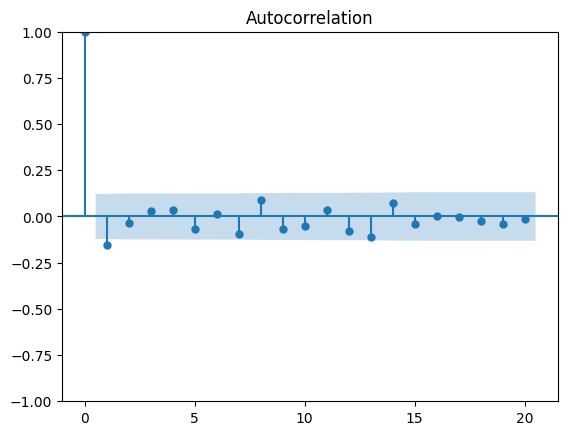

In [18]:
# Compute the percentage change of prices
returns = MSFT.pct_change()
returns = returns.dropna()

# Compute and print the autocorrelation of MSFT weekly returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly MSFT returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(returns, alpha=0.05, lags=20)
plt.show()

Notice that the autocorrelation with lag 1 is significantly negative, but none of the other lags are significantly different from zero.

#### White Noise

A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

We will generate a white noise series and plot the autocorrelation function to show that it is zero for all lags. We can use `np.random.normal()` to generate random returns. For a Gaussian white noise process, the mean and standard deviation describe the entire process.

The mean is 0.020 and the standard deviation is 0.051


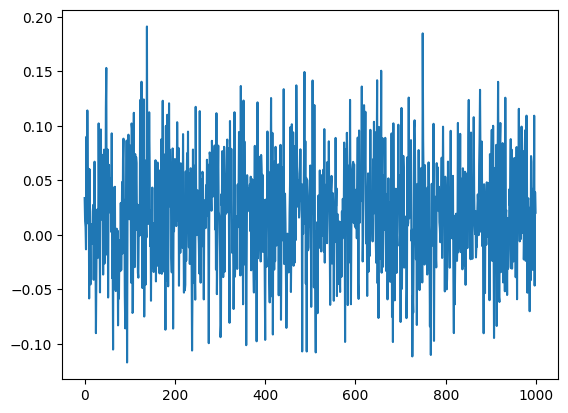

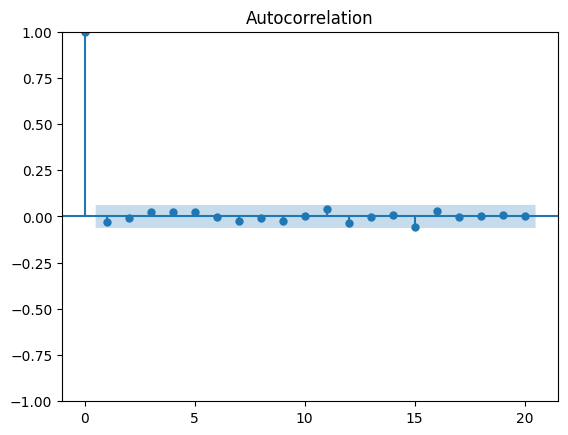

In [19]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show()

Notice that for a white noise time series, all the autocorrelations are close to zero, so the past will not help you forecast the future.

#### Random Walk

Whereas stock returns are often modeled as white noise, stock prices closely follow a random walk. In other words, today's price is yesterday's price plus some random noise.

We will simulate the price of a stock over time that has a starting price of 100 and every day goes up or down by a random amount. Then, plot the simulated stock price.

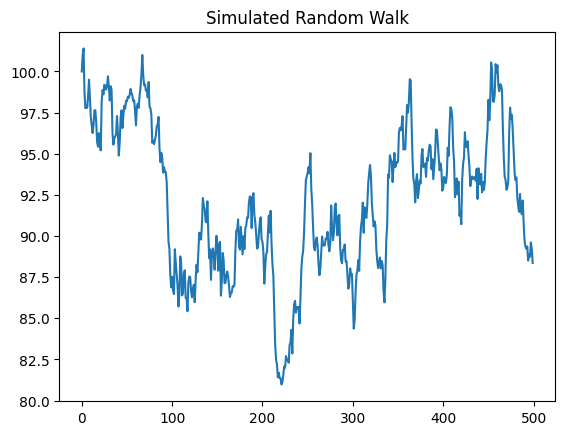

In [20]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()

The simulated price series we plotted should closely resemble a random walk.


Now, we will look at a random walk with a drift. Many time series, like stock prices, are random walks but tend to drift up over time.
In the last exercise, the noise in the random walk was additive: random, normal changes in price were added to the last price. However, when adding noise, we could theoretically get negative prices. Now we will make the noise multiplicative: we will add one to the random, normal changes to get a total return, and multiply that by the last price.

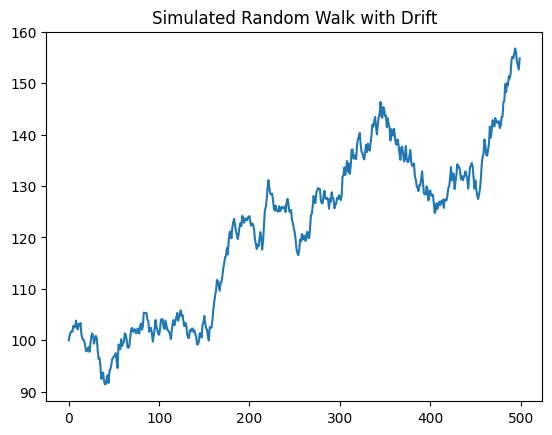

In [21]:
# Generate 500 random steps
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()

This simulated price series you plotted should closely resemble a random walk for a high flying stock.

Most stock prices follow a random walk (perhaps with a drift). We will look at a time series of Amazon stock prices and run the 'Augmented Dickey-Fuller Test' from the statsmodels library to show that it does indeed follow a random walk.

With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

In [22]:
AMZN = pd.read_csv("data_1\AMZN.csv", parse_dates = ['Date'], index_col='Date')
AMZN.head()

,Adj Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


In [23]:
# Run the ADF test on the price series and print out the results
results = adfuller(AMZN['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.02516852577074, 1.0, 33, 5054, {'1%': -3.4316445438146865, '5%': -2.862112049726916, '10%': -2.5670745025321304}, 30308.64216426981)
The p-value of the test on prices is: 1.0


According to this test, we cannot reject the hypothesis that Amazon prices follow a random walk. Now, we'll look at Amazon returns. We  will do the same thing for Amazon returns (percent change in prices) and show that the returns do not follow a random walk.

In [24]:
# Create a DataFrame of AMZN returns
AMZN_ret = AMZN.pct_change()

# Eliminate the NaN in the first row of returns
AMZN_ret = AMZN_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(AMZN_ret['Adj Close'])
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.56558980834849e-22


The p-value is extremely small, so we can easily reject the hypothesis that returns are a random walk at all levels of significance.

#### Stationarity

Many time series exhibit strong seasonal behavior. The procedure for removing the seasonal component of a time series is called seasonal adjustment. For example, most economic data published by the government is seasonally adjusted.

You saw earlier that by taking first differences of a random walk, we get a stationary white noise process. For seasonal adjustments, instead of taking first differences, we will take differences with a lag corresponding to the periodicity.

Look again at the ACF of H&R Block's quarterly earnings, there is a clear seasonal component. The autocorrelation is high for lags 4,8,12,16,… because of the spike in earnings every four quarters during tax season. We will apply a seasonal adjustment by taking the fourth difference (four represents the periodicity of the series). Then compute the autocorrelation of the transformed series.

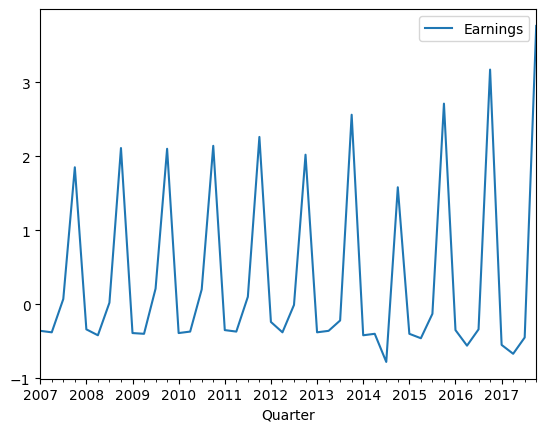

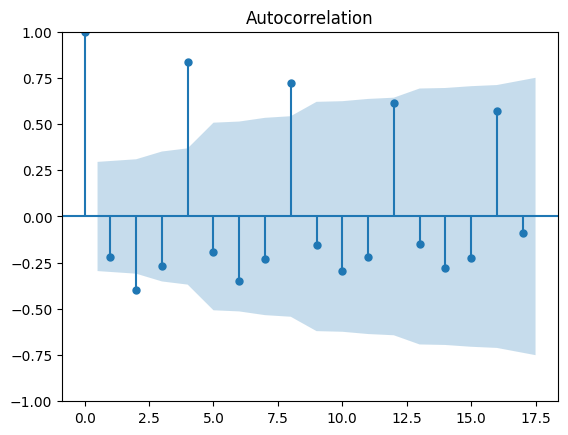

In [25]:
HRB.plot()
plt.show()

# Plot the acf function
plot_acf(HRB)
plt.show()

            Earnings
Quarter             
2007-01-01       NaN
2007-04-01       NaN
2007-07-01       NaN
2007-10-01       NaN
2008-01-01      0.02
2008-04-01     -0.04
2008-07-01     -0.05
2008-10-01      0.26
2009-01-01     -0.05
2009-04-01      0.02


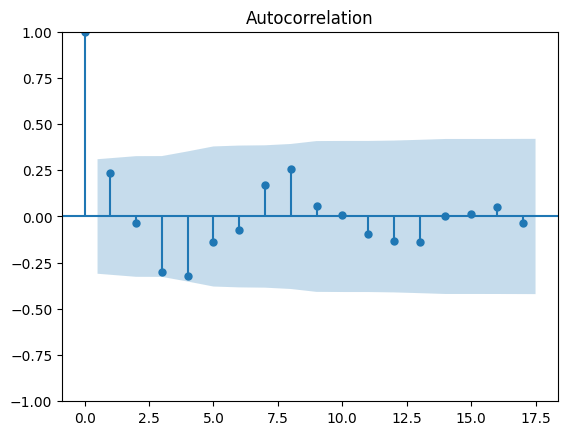

In [26]:
# Seasonally adjust quarterly earnings
HRBsa = HRB.diff(4)

# Print the first 10 rows of the seasonally adjusted series
print(HRBsa.head(10))

# Drop the NaN data in the first four rows
HRBsa = HRBsa.dropna()

# Plot the autocorrelation function of the seasonally adjusted series
plot_acf(HRBsa)
plt.show()

By seasonally adjusting the series, we eliminated the seasonal pattern in the autocorrelation function.

## 3. Autoregressive (AR) Models
In this chapter we'll learn about autoregressive, or AR, models for time series. These models use past values of the series to predict the current value.

#### Describe AR Model

$$ R_t = \mu + \phi R_{t-1} + \epsilon _t$$

We will simulate and plot a few AR(1) time series, each with a different parameter, $\phi$, using the `arima_process` module in statsmodels. In this exercise, we will look at an AR(1) model with a large positive $\phi$ and a large negative $\phi$.

There are a few conventions when using the `arima_process` module that require some explanation. First, these routines were made very generally to handle both AR and MA models. We will cover MA models next, so for now, just ignore the MA part. Second, when inputting the coefficients, we must include the zero-lag coefficient of 1, and the sign of the other coefficients is opposite what we have been using (to be consistent with the time series literature in signal processing). For example, for an AR(1) process with 
$\phi$, the array representing the AR parameters would be `ar = np.array([1, -0.9])`.

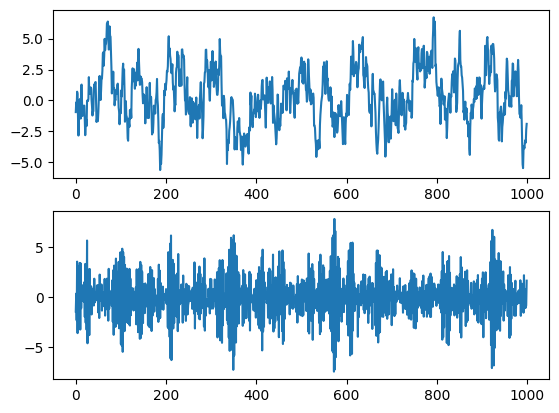

In [27]:
# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

The two AR parameters produce very different looking time series plots, but in the next exercise we'll really be able to distinguish the time series.

The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter. For example, if the AR parameter, $\phi=+0.9$, the first-lag autocorrelation will be 0.9, the second-lag will be $(0.9)^2=0.81$, the third-lag will be $(0.9)^3=0.729$, etc. A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be $(-0.9)^2=0.81$, the third-lag will be $(-0.9)^3=-0.729$
, etc.

In [28]:
# AR parameter = +0.3
ar3 = np.array([1, -0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)

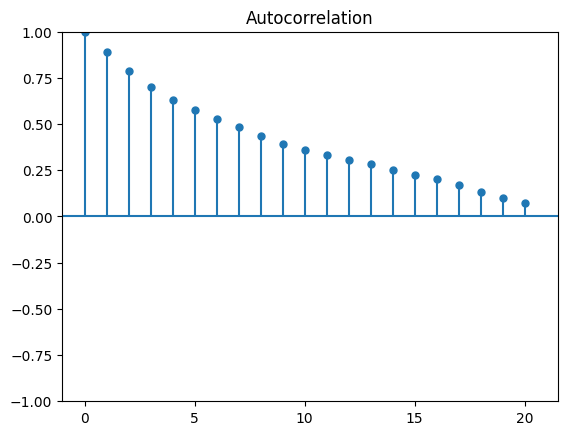

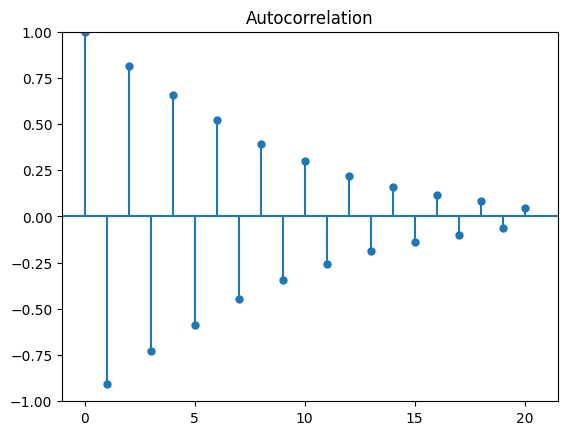

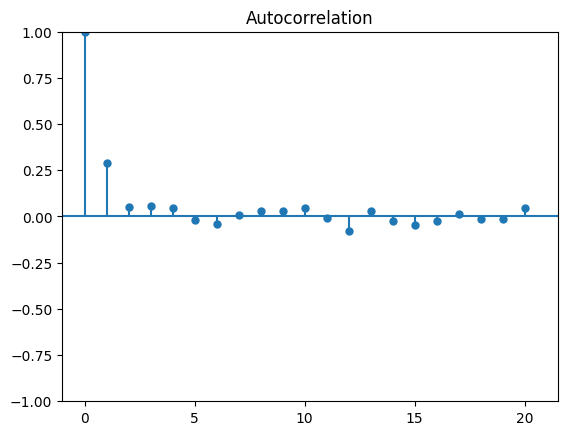

In [29]:
# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show()

# Plot 3: AR parameter = +0.3
plot_acf(simulated_data_3, alpha=1, lags=20)
plt.show()

#### Estimating and Forecasting AR Model

We will estimate the AR(1) parameter, $\phi$, of one of the simulated series that we generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For `simulated_data_1` with a true $\phi$ of 0.9, we will print out the estimate of  $\phi$. In addition, we will also print out the entire output that is produced when we fit a time series, so we can get an idea of what other tests and summary statistics are available in statsmodels.

In [30]:
# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1, 0, 0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for phi
print("When the true phi=0.9, the estimate of phi is:")
print(res.params[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1417.706
Date:                Fri, 07 Apr 2023   AIC                           2841.411
Time:                        11:12:57   BIC                           2856.135
Sample:                             0   HQIC                          2847.007
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3160      0.290      1.089      0.276      -0.253       0.885
ar.L1          0.8913      0.014     61.843      0.000       0.863       0.920
sigma2         0.9960      0.045     22.269      0.0

In addition to estimating the parameters of a model that we did in the last exercise, we can also do forecasting, both in-sample and out-of-sample using statsmodels. The in-sample is a forecast of the next data point using the data up to that point, and the out-of-sample forecasts any number of data points in the future. We can plot the forecasted data using the function plot_predict(). We supply the starting point for forecasting and the ending point, which can be any number of data points after the data set ends.

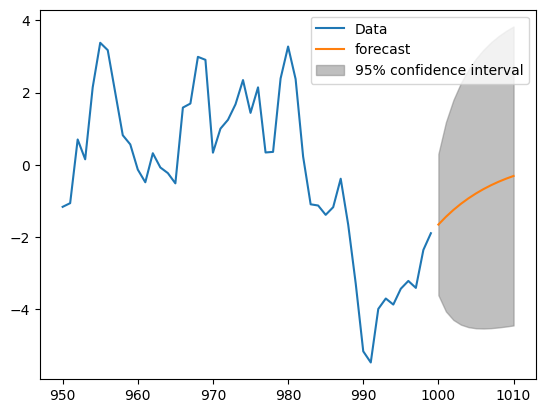

In [31]:
df_sim_1 = pd.DataFrame(simulated_data_1, columns = ['Data'])

# Forecast the first AR(1) model
mod = ARIMA(df_sim_1, order=(1, 0, 0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
df_sim_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

Notice how, when phi is high like here, the forecast gradually moves to the long term mean of zero, but if phi were low, it would move much quicker to the long term mean. 

We will now use the forecasting techniques we learned in the last exercise and apply it to real data rather than simulated data. We will use a dataset: the annual data of 10-year interest rates going back 56 years, which is in a Series called `interest_rate_data`. Being able to forecast interest rates is of enormous importance, not only for bond investors but also for individuals like new homeowners who must decide between fixed and floating rate mortgages.

We saw in the first chapter that there is some mean reversion in interest rates over long horizons. In other words, when interest rates are high, they tend to drop and when they are low, they tend to rise over time. Currently they are below long-term rates, so they are expected to rise, but an AR model attempts to quantify how much they are expected to rise.

In [32]:
interest_rate_data = pd.read_csv("data_1/10_year_interest_rates_a.csv", parse_dates = ['DATE'], index_col='DATE')
interest_rate_data = interest_rate_data.asfreq('A', method='ffill')
interest_rate_data.head()

,US10Y
DATE,
1962-12-31,3.946064
1963-12-31,4.001566
1964-12-31,4.187360
1965-12-31,4.283695
1966-12-31,4.925040


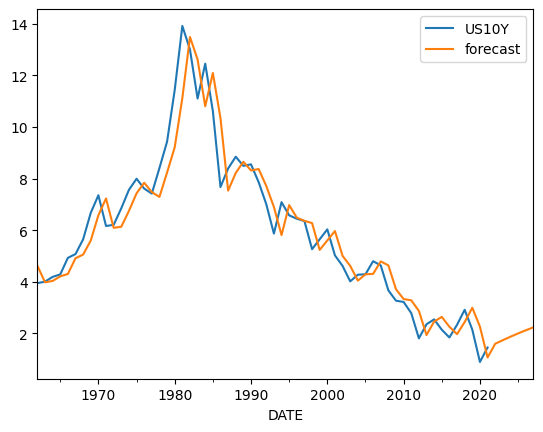

In [33]:
# Forecast interst rates using an AR(1) model
mod = ARIMA(interest_rate_data, order=(1, 0, 0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
interest_rate_data.plot(ax=ax)
plot_predict(res, start=0, end='2027', alpha=None, ax=ax)
plt.show()

According to an AR(1) model, 10-year interest rates are forecasted to rise from 1.44%, towards the end of 2027 to >2% in five years.

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. We will compare the ACF for the slightly mean-reverting interest rate series of the last exercise with a simulated random walk with the same number of observations.

We should notice when plotting the autocorrelation of these two series side-by-side that they look very similar.

In [34]:
simulated_data = [5.        , 4.77522278, 5.60354317, 5.96406402, 5.97965372, 
                  6.02771876, 5.5470751 , 5.19867084, 5.01867859, 5.50452928,
                  5.89293842, 4.6220103 , 5.06137835, 5.33377592, 5.09333293,
                  5.37389022, 4.9657092 , 5.57339283, 5.48431854, 4.68588587,
                  5.25218625, 4.34800798, 4.34544412, 4.72362568, 4.12582912,
                  3.54622069, 3.43999885, 3.77116252, 3.81727011, 4.35256176,
                  4.13664247, 3.8745768 , 4.01630403, 3.71276593, 3.55672457,
                  3.07062647, 3.45264414, 3.28123729, 3.39193866, 3.02947806,
                  3.88707349, 4.28776889, 3.47360734, 3.33260631, 3.09729579,
                  2.94652178, 3.50079273, 3.61020341, 4.23021143, 3.94289347,
                  3.58422345, 3.18253962, 3.26132564, 3.19777388, 3.43527681,
                  3.37204482
                 ]

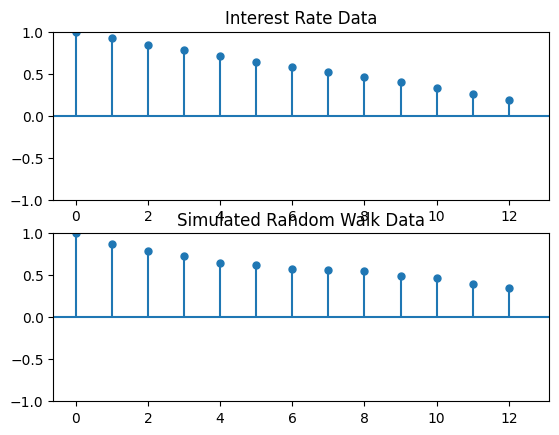

In [35]:
# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
fig = plot_acf(interest_rate_data, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
fig = plot_acf(simulated_data, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")
plt.show()

Notice the Autocorrelation functions look very similar for the two series.

#### Choosing the Right Model

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). In this exercise, we will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. You will notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

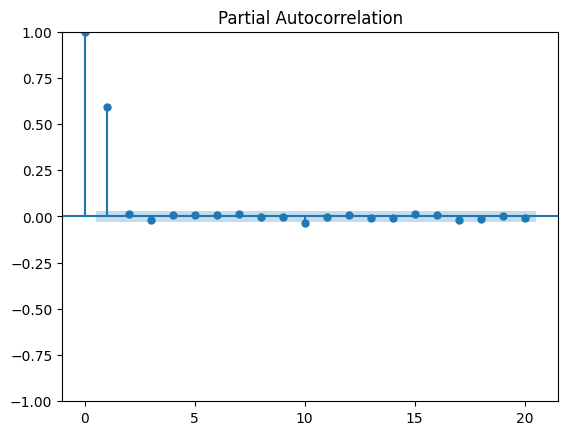

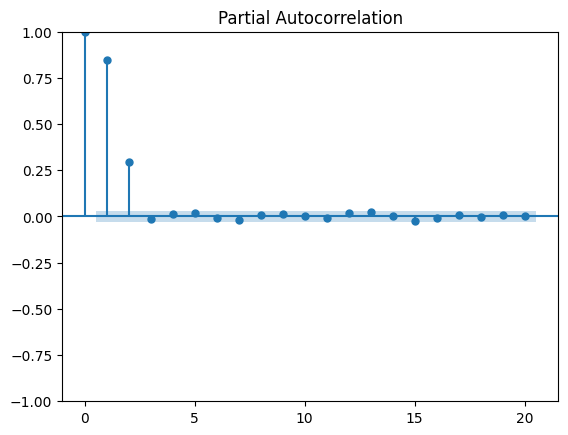

In [36]:
# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20, method='ywm')
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20, method='ywm')
plt.show()

Notice that the number of significant lags for the PACF indicate the order of the AR model.

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. We will take the AR(2) simulated data from the last exercise, saved as `simulated_data_2`, and compute the BIC as we vary the order, p, in an AR(p) from 0 to 6.

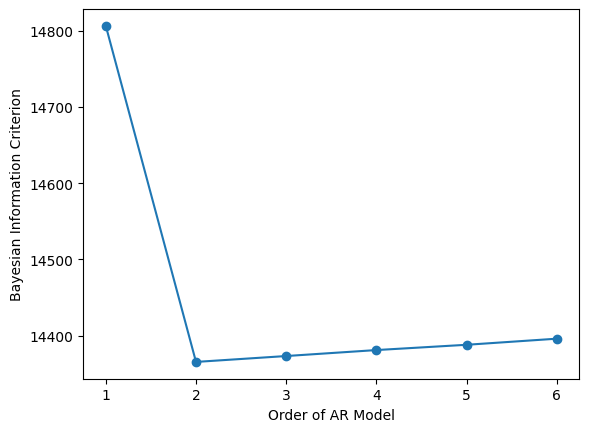

In [37]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_2, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

For an AR(2), the BIC achieves its minimum at p=2, which is what we expect.

## 4. Moving Average (MA) and ARMA Models
In this chapter we'll learn about another kind of model, the moving average, or MA, model. We will also see how to combine AR and MA models into a powerful ARMA model.

#### Describe Model

We will simulate and plot a few MA(1) time series, each with a different parameter, $\theta$, using the `arima_process` module in statsmodels, just as we did in the last chapter for AR(1) models. We will look at an MA(1) model with a large positive $\theta$ and a large negative $\theta$.

As in the last chapter, when inputting the coefficients, we must include the zero-lag coefficient of 1, but unlike the last chapter on AR models, the sign of the MA coefficients is what we would expect. For example, for an MA(1) process with $\theta$ = -0.9, the array representing the MA parameters would be ma = np.array([1, -0.9]).

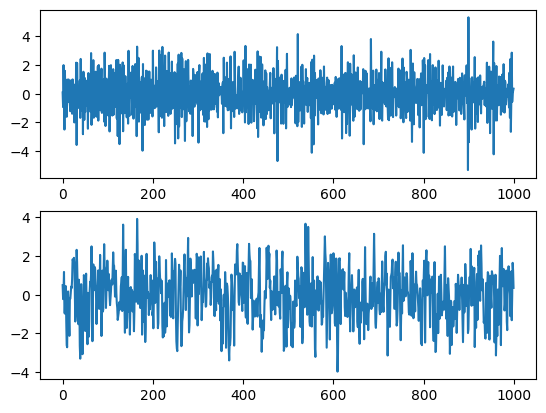

In [38]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

The two MA parameters produce different time series plots, but in the next exercise we'll really be able to distinguish the time series.

Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. The lag-1 autocorrelation for an MA(1) model is not $\theta$, but rather $\theta / (1 + \theta ^2)$. For example, if the MA parameter, $\theta$, is = +0.9, the first-lag autocorrelation will be $0.9 / (1 + 0.9 ^2) = 0.497$, and the autocorrelation at all other lags will be zero. If the MA parameter, $\theta$, is = -0.9, the first-lag autocorrelation will be $-0.9 / (1 + (-0.9)^2) = -0.497$.

We will verify these autocorrelation functions for the three time series we generated in the last exercise.

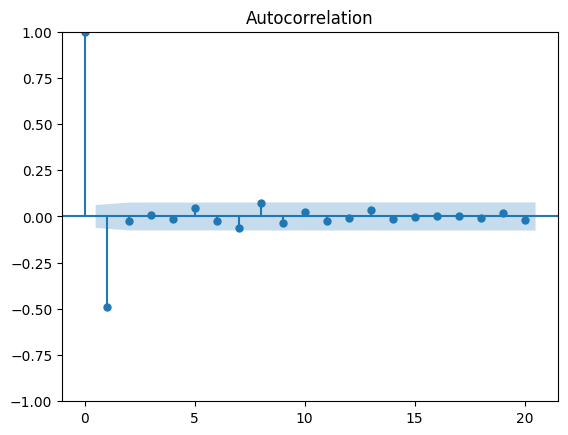

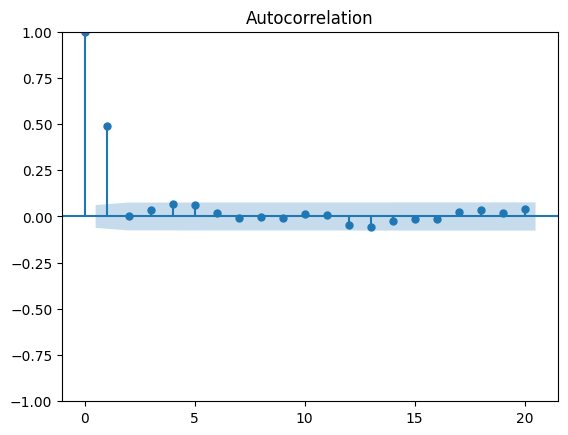

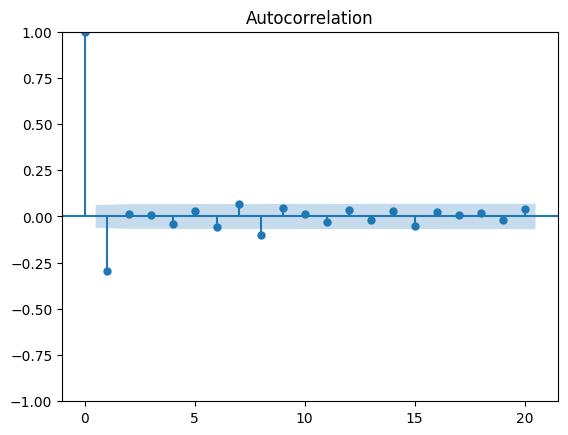

In [39]:
# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20)
plt.show()

# Plot 2: MA parameter = 0.9
plot_acf(simulated_data_2, lags=20)
plt.show()

# Plot 3: MA parameter = -0.3
ar3 = np.array([1])
ma3 = np.array([1, -0.3])
MA_object1 = ArmaProcess(ar3, ma3)
simulated_data_3 = MA_object1.generate_sample(nsample=1000)
plot_acf(simulated_data_3, lags=20)
plt.show()

#### Estimation and Forecasting an MA Model

We will estimate the MA(1) parameter, $\theta$, of one of the simulated series that we generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For `simulated_data_1` with a true $\theta$ of -0.9, we will print out the estimate of $\theta$. In addition, we will also print out the entire output that is produced when we fit a time series, so we can get an idea of what other tests and summary statistics are available in statsmodels.

In [40]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0, 0, 1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1430.624
Date:                Fri, 07 Apr 2023   AIC                           2867.248
Time:                        11:13:04   BIC                           2881.971
Sample:                             0   HQIC                          2872.843
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.979      0.328      -0.002       0.007
ma.L1         -0.9284      0.012    -77.193      0.000      -0.952      -0.905
sigma2         1.0216      0.048     21.221      0.0

As we did with AR models, we will use MA models to forecast in-sample and out-of-sample data using the `plot_predict()` function in statsmodels.

For the simulated series `simulated_data_1` with $\theta = -0.9$, we will plot in-sample and out-of-sample forecasts. One big difference we will see between out-of-sample forecasts with an MA(1) model and an AR(1) model is that the MA(1) forecasts more than one period in the future are simply the mean of the sample.

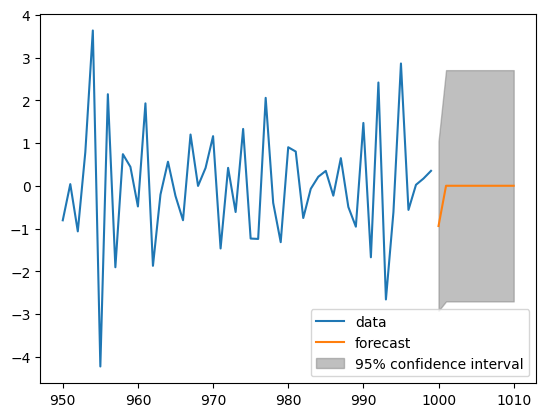

In [41]:
df_simulated_data_1 = pd.DataFrame({'data': simulated_data_1})

# Forecast the first MA(1) model
mod = ARIMA(df_simulated_data_1, order=(0, 0, 1))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
# in-sample data starting with data point 950
df_simulated_data_1.loc[950:].plot(ax=ax)
# out-of-sample forecasts of the data and confidence intervals
# starting with data point 1000 and ending the forecast at point 1010
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

Notice that the out-of-sample forecasts are flat into the future after the first data point.

#### ARMA models

Higher frequency stock data is well modeled by an MA(1) process, so it's a nice application of the models in this chapter.

The DataFrame `intraday` contains one day's prices (on September 1, 2017) for Sprint stock (ticker symbol "S") sampled at a frequency of one minute. The stock market is open for 6.5 hours (390 minutes), from 9:30am to 4:00pm.

Before we can analyze the time series data, we will have to clean it up a little, which we will do in this and the next two exercises. When we look at the first few rows, we'll notice several things. First, there are no column headers. The data is not time stamped from 9:30 to 4:00, but rather goes from 0 to 390. And we will notice that the first date is the odd-looking "a1504272600". The number after the "a" is Unix time which is the number of seconds since January 1, 1970. This is how this dataset separates each day of intraday data.

If we look at the data types, we'll notice that the DATE column is an object, which here means a string. We will need to change that to numeric before we can clean up some missing data.

The source of the minute data is Google Finance (see [here](https://www.quantshare.com/sa-426-6-ways-to-download-free-intraday-and-tick-data-for-the-us-stock-market) on how the data was downloaded).

In [42]:
# loda data
intraday = pd.read_csv("data_1/Sprint_Intraday.txt", sep=",", header=None)
intraday = intraday[[0, 1]]
intraday.head()

,0,1
0,a1504272600,8.2900
1,1,8.2700
2,2,8.2800
3,3,8.2750
4,4,8.2875


In [43]:
# Change the first date to zero
intraday.iloc[0,0] = 0

# Change the column headers to 'DATE' and 'CLOSE'
intraday.columns = ['DATE', 'CLOSE']

# Examine the data types for each column
print(intraday.dtypes)

# Convert DATE column to numeric
intraday['DATE'] = pd.to_numeric(intraday['DATE'])

# Make the `DATE` column the new index
intraday = intraday.set_index('DATE')

DATE      object
CLOSE    float64
dtype: object


When we print out the length of the DataFrame `intraday`, we will notice that a few rows are missing. There will be missing data if there are no trades in a particular one-minute interval. One way to see which rows are missing is to take the difference of two sets: the full set of every minute and the set of the DataFrame index which contains missing rows. After filling in the missing rows, we can convert the index to time of day and then plot the data.

Stocks trade at discrete one-cent increments (although a small percentage of trades occur in between the one-cent increments) rather than at continuous prices, and when we plot the data we should observe that there are long periods when the stock bounces back and forth over a one cent range. This is sometimes referred to as "bid/ask bounce".

If there were no missing rows, there would be 391 rows of minute data
The actual length of the DataFrame is: 389
Missing rows:  {182, 14}


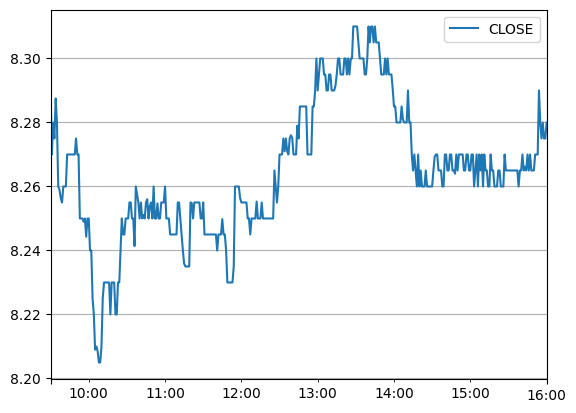

In [44]:
# Notice that some rows are missing
print("If there were no missing rows, there would be 391 rows of minute data")
print("The actual length of the DataFrame is:", len(intraday))

# Everything
set_everything = set(range(391))

# The intraday index as a set
set_intraday = set(intraday.index)

# Calculate the difference
set_missing = set_everything - set_intraday

# Print the difference
print("Missing rows: ", set_missing)

# Fill in the missing rows
intraday = intraday.reindex(range(391), method='ffill')

# From previous step
intraday = intraday.reindex(range(391), method='ffill')

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

# Plot the intraday time series
intraday.plot(grid=True)
plt.show()

The bouncing of the stock price between bid and ask induces a negative first order autocorrelation, but no autocorrelations at lags higher than 1. We get the same ACF pattern with an MA(1) model. Therefore, we will fit an MA(1) model to the intraday stock data from the last exercise.

The first step is to compute minute-by-minute returns from the prices in intraday, and plot the autocorrelation function. We should observe that the ACF looks like that for an MA(1) process. Then, fit the data to an MA(1), the same way we did for simulated data.

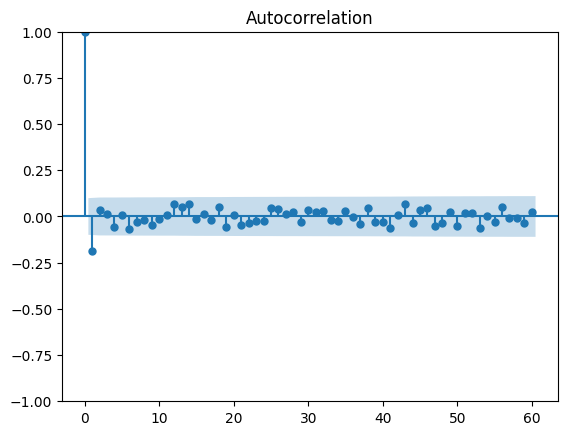

-0.1717161939480059


In [45]:
# Compute returns from prices and drop the NaN
returns = intraday.pct_change()
returns = returns.dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60)
plt.show()

# Fit the data to an MA(1) model
mod = ARIMA(returns, order=(0,0,1))
res = mod.fit()
print(res.params[1])

Notice the significant negative lag-1 autocorrelation, just like for an MA(1) model.

To better understand the relationship between MA models and AR models, we will demonstrate that an AR(1) model is equivalent to an MA($\infty$) model with the appropriate parameters. We will simulate an MA model with parameters $0.8, 0.8^2, 0.8^3...$ for a large number (30) lags and show that it has the same Autocorrelation Function as an AR(1) model with $\phi = 0.8$.

$$R_t = \mu + \phi R_{t-1} + \epsilon_t$$
$$R_t = \mu + \phi (\mu + \phi R_{t-2} + \epsilon_{t-1}) + \epsilon_t$$
$$\vdots$$
$$R_t = \frac{\mu}{1-\phi} + \epsilon_t + \phi \epsilon_{t-1} + \phi^2 \epsilon_{t-2} + \phi^3 \epsilon_{t-3} + ...$$ 

Note, to raise a number `x` to the power of an exponent `n`, use the format `x**n`.

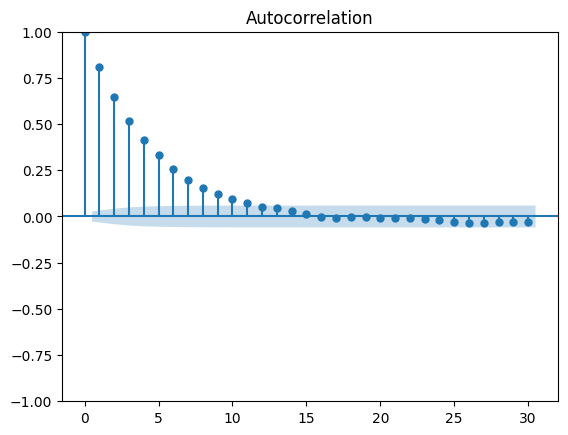

In [46]:
# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

## 5. Putting It All Together
This chapter will show us how to model two series jointly using cointegration models. Then we'll wrap up with a case study where we look at a time series of temperature data from New York City.

#### Cointegration Models

What is Cointegration?
- Two series, $P_t$ and $Q_t$ can be random walks.
- But the linear combination $P_t − c Q_t$ may not be a random walk!
- If that's true:
    - $P_t − c Q_t$ is forecastable
    - $P_t$ and $Q_t$ are said to be cointegrated

The Heating Oil and Natural Gas prices are pre-loaded in DataFrames `HO` and `NG`. First, we will plot both price series, which look like random walks. Then, we will plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we will multiply the heating oil prices, in \\$/gallon, by 7.25, which converts it to \\$/millionBTU, which is the same units as Natural Gas).

In [53]:
HO = pd.read_csv("data_1/CME_HO1.csv", parse_dates=["Date"], index_col="Date")
NG = pd.read_csv("data_1/CME_NG1.csv", parse_dates=["Date"], index_col="Date")

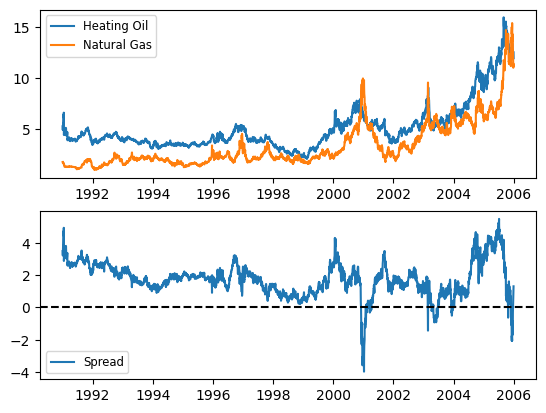

In [54]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.

To verify that Heating Oil and Natural Gas prices are cointegrated, First we will apply the Dickey-Fuller test separately to show they are random walks. Then we will apply the test to the difference, which should strongly reject the random walk hypothesis. 

In [55]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.019831028071627756
The p-value for the ADF test on NG is  0.004547284956542337
The p-value for the ADF test on the spread is  0.00011887051827353336


As we expected, we cannot reject the hypothesis that the individual futures are random walks, but we can reject that the spread is a random walk.

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was $(1, -1)$. In other words, we took the difference between the two series (after doing a units conversion). Here, we will do both steps.

We will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient $b$, then the cointegration vector is simply $(1, -b)$. Then, we will perform the ADF test on BTC$-b$ETH. The Bitcoin and Ethereum prices data was downloaded from the [Cryptocurrency Historical Prices](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory?resource=download&select=coin_Ethereum.csv). 

In [75]:
BTC = pd.read_csv("data_1/crypto/coin_Bitcoin.csv", parse_dates=['Date'], index_col=['Date'])
BTC = BTC['Close']
ETH = pd.read_csv("data_1/crypto/coin_Ethereum.csv", parse_dates=['Date'], index_col=['Date'])
ETH = ETH['Close']
print("The length of the BTC table is {}.".format(len(BTC)))
print("The length of the ETH table is {}.".format(len(ETH)))

The length of the BTC table is 2991.
The length of the ETH table is 2160.


The `BTC` and `ETH` are not equal in their length. First, we will find out which dates are missing in the `ETH`. Then, we will simply remove these dates from `BTC`.

In [76]:
# find out which dates are missing
dates_to_remove = set(BTC.index) - set(ETH.index)
# remove rows
BTC = BTC.drop(dates_to_remove)

In [79]:
# Regress BTC on ETH 
# sm.OLS(y,x).fit(), where y is the dependent variable and x is the independent variable
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC, ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC - b*ETH['Close'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.0008035691342758137


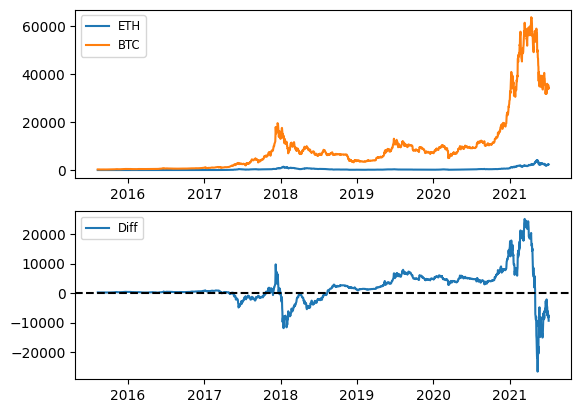

In [80]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(ETH['Close'], label='ETH')
plt.plot(BTC, label='BTC')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(BTC - b*ETH['Close'], label='Diff')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

The data suggests that Bitcoin and Ethereum are cointegrated.

#### Case Study: Climate Change

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this training.

The DataFrame `temp_NY` contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA [here](https://www.ncdc.noaa.gov/cdo-web/search)). First, we will plot the data and test whether it follows a random walk (with drift).

In [131]:
temp_NY = pd.read_csv("data_1/ny_temp.csv", parse_dates=["DATE"], index_col="DATE")
temp_NY = temp_NY.drop("Unnamed: 0",axis=1)
temp_NY.head()

,TAVG
DATE,
1870-01-01,53.8
1871-01-01,51.3
1872-01-01,51.3
1873-01-01,50.9
1874-01-01,51.3


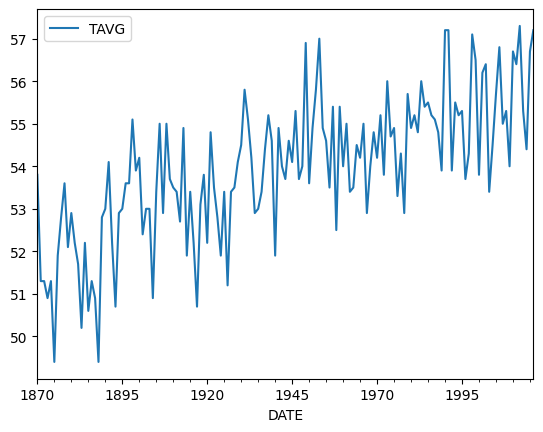

The p-value for the ADF test is  0.5832938987871121


In [132]:
# # Convert the format of the datetime
# temp_NY.index = temp_NY.index.strftime('%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The data seems to follow a random walk with drift.

Since the temperature series, `temp_NY`, is a random walk with drift, we will take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


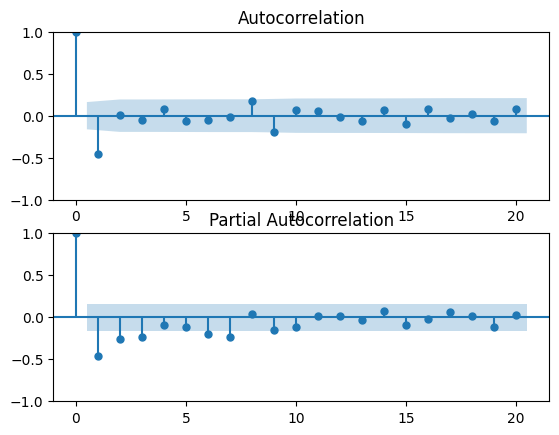

In [133]:
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF.

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower [AIC](https://otexts.com/fpp2/arima-estimation.html) scores are better.

We will fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [134]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 1, 0))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  510.5346898733109
The AIC for an AR(2) is:  501.92741234091363
The AIC for an ARMA(1,1) is:  611.566505797921


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Pyt

The AR(2) has the lowest AIC values among the three models. (Based on the DATA CAMP it should be ARMA(1,1), not sure why since I recived the same results as in the online training)

Finally, we will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. We need to keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, we determined that the temperature data follows a random walk and we looked at first differencing the data. In this exercise, we will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, we will also need to add a trend component when we define the ARIMA model. In the exercise, we'll use a linear trend with time by setting the argument trend='t'. We can also try other trend models to see how the forecasts change. For example, for a quadratic trend $a+bt+ct^2$, set trend=[0,1,1], to include both a linear term, $bt$, and quadratic term, $ct^2$, in the model.

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


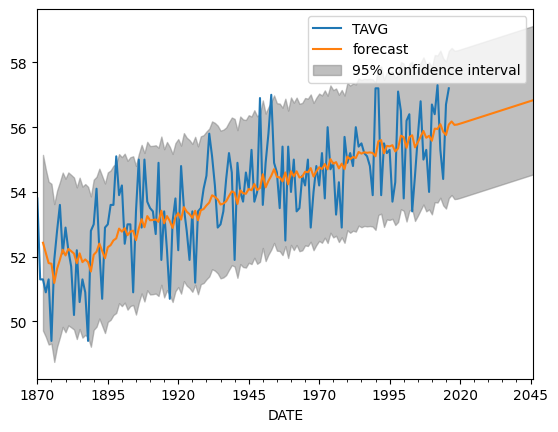

In [136]:
# Create an instance of the ARIMA class called mod for an integrated ARMA(1,1) model, or ARIMA(1,1,1) model
# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.